# Pytorch vs tf

Pytorch est considéré comme étant plus pythonesque, c'est à dire plus proche de l'utilisation des objets python.
Dans tf (V1) on définit notre graphe, on compile puis on vient nourir le graphe grâce aux placeholders pour lancer l'entrainement.
Pytorch se lance dynamiquement, comme du code python classique. (Le graphe du modèle va se définir automatiquement au fur et à mesure)
Tensorflow avait une plus grosse communauté mais cela tend à s'équilibrer voir à s'inverser dans le NLP. LA recherche semble plus utiliser Pytorch.

Pytorch semble également être légèrement plus performant. Nous allons voir quelques opérations simples, puis nous implémenterons un réseau feed forward.

Il existe deux autres api : torchvision et torchtext qui permettent d'accélérer le développement de projets de visions ou de nlp. Vous pouvez importer directement des modèles, ou importez des layers spécifiques ( MAxPooling, Embedding, etc.)

In [1]:
import torch
import numpy as np

In [2]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)
x_data

tensor([[1, 2],
        [3, 4]])

In [3]:
print(x_data.size())

torch.Size([2, 2])


In [4]:
print(x_data.dim())

2


##### From numpy

In [5]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)
x_np

tensor([[1, 2],
        [3, 4]])

In [6]:
#Matrice randomisée
x_np_rand = torch.rand_like(x_data, dtype=torch.float)
x_np_rand

tensor([[0.4500, 0.1729],
        [0.4879, 0.5808]])

### opérations : 

In [7]:
x_np +  x_np_rand

tensor([[1.4500, 2.1729],
        [3.4879, 4.5808]])

On peut observer que contrairement à tensorflow le calcul est directement effectué, d'où le côté plus "pythonic" !

In [8]:
torch.add(x_np,  x_np_rand) # une autre manière de réaliser le calcul, comme tensoflow

tensor([[1.4500, 2.1729],
        [3.4879, 4.5808]])

In [9]:
x_np[1:2] #slice fonctionne également

tensor([[3, 4]])

# Neural network

L'heure du premier réseau de neurones sous torch est arrivé ! 

In [10]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 

from IPython.display import HTML
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs


In [11]:
import torch.nn.functional as F

# Get data

Pour ne pas perdre de temps avec les données on va générer des données à l'aide de sklean

(10000, 2) (10000,)


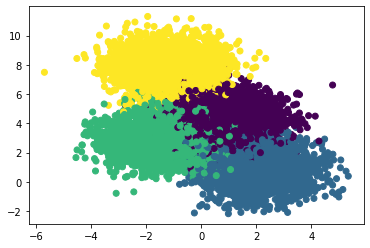

(7500, 2) (2500, 2) (10000,)


In [12]:
#on génère 10000 lignes composées de 2 features, réparties en 4 classes. N'hésitez pas à jouer avec ces paramètres.
data, labels = make_blobs(n_samples=10000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

#on visualisez les données
plt.scatter(data[:,0], data[:,1], c=labels)
plt.show()

#on utilise sklean pour séparer les données, comme habituellement
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, X_val.shape, labels.shape)

### convertion en tensor

Comme pour tensorflow, pour fournir les données au modèle il faut les convertir en tensor, pour respecter le format torch

In [13]:

X_train, Y_train, X_val, Y_val = map(torch.tensor, (X_train, Y_train, X_val, Y_val))
print(X_train.shape, Y_train.shape)

X_train = X_train.float()
Y_train = Y_train.long()
X_val = X_val.float()
Y_val = Y_val.long()

torch.Size([7500, 2]) torch.Size([7500])


### Entrainement

On commence par importer les principales briques qui vont nous permettre de construire notre réseau

In [14]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from sklearn.metrics import accuracy_score

##### Définition du modèle
On va construire une class qui va définir l'architecture de notre modèle. Elle hérite de torch.nn.Module.
Il faut définir dans l'init les différentes couches. On va utiliser pour cela la méthode "Linear(p1,p2)" de torch qui est l'équivalent de "Dense" sous keras. Deux paramètres : p1 correspond à la taille d'entrée et p2 la taille de sortie.
Il faut définir à chaque fois de quelle manière on va initialiser les poids de cette couche, plusieurs méthodes existent : kaiming_uniform_ ou xavier_initialisation. 

Enfin pour faire une classification vous pouvez utiliser en dernière couche une Softmax


Dans cette classe on va également définir la méthode forward, elle décrit explicitement le lien entre les couches définies dans l'init.

Dans la méthode predict on va utiliser self(X_pred) afin d'obtenir la sortie de la couche Softmax. Pour retourner a la prédiction d'une et une seule classe par ligne on va utiliser torch.argmax.

Enfin pour la méthode évaluation, on va se servir de la méthode prédiction en calculant un score d'accuracy (metric de sklean).

In [17]:
# model definition
class MLP(nn.Module):
    # define model elements
    def __init__(self, n_inputs, n_output):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, 10)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # second hidden layer
        self.hidden2 = Linear(10, n_output)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = Softmax(dim=1)

    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # output layer
        return X
    
    def prediction(self, X_pred):
        return torch.argmax(self(X_pred), dim=1)
    
    def evaluation(self, X_pred, Y_true):
        return accuracy_score(self.prediction(X_pred), Y_true)

In [18]:
n_input = X_train.size()[1]
n_output = Y_train.unique().shape[0]
model = MLP(n_input,n_output ) # on instantie l'objet

# Dans la méthode fit on va configurer l'entrainement. La syntaxe se démarque de tensorflow, il faut ici définir les étapes de l'entrainement :
# 1) on calcule la loss à l'aide de la méthode backward()
# 2) on calcule le gradient pour tous les paramètres (backpropagation)
# 3) on change la valeur des poids à l'aide de la méthode step()
# 4) on vide la valeur des gradients (buffer) 

def fit(x, y, model, opt, loss_fn, epochs = 100):
    """Generic function for training a model """
    for epoch in range(epochs):
        
        loss = loss_fn(model(x), y)  # on calcule la loss

        loss.backward() # calcule le gradient pour toutes les variables et l'ajoute au buffer
        opt.step() # MAJ des poids 
        opt.zero_grad() # on nettoie le buffer des gradients calculé avec loss.backward()
        if epoch % 5 ==0:
            print(epoch)
            print(loss.item())
    return loss.item()

# loss 
loss_fn = nn.CrossEntropyLoss()

# optimizer 
#comme pour tf il en existe pleins : SGD, ADAMW, ADAGRAD => https://pytorch.org/docs/stable/optim.html
opt = SGD(model.parameters(), lr=0.01, momentum=0.9)


#entrainement du modèle 
fit(X_train, Y_train, model, opt, loss_fn)

0
1.383244514465332
5
1.3463259935379028
10
1.2676202058792114
15
1.2700129747390747
20
1.2611489295959473
25
1.2283741235733032
30
1.2083125114440918
35
1.182125449180603
40
1.1619642972946167
45
1.1536043882369995
50
1.1427005529403687
55
1.1341688632965088
60
1.128607988357544
65
1.1239341497421265
70
1.1204274892807007
75
1.1174637079238892
80
1.1148489713668823
85
1.112701654434204
90
1.1108397245407104
95
1.109170913696289


1.10797119140625

In [19]:
model.prediction(X_val)

tensor([0, 3, 1,  ..., 3, 0, 1])

In [20]:
model.evaluation(X_val, Y_val)

0.6588